# Task 1: Working with a dataset with categorical features

### Step 1, Reading the data

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import krippendorff
import torch 

class TDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])
    
class DataSetContainer():
    def __init__(self, RawY=None, RawX=None, File=None, Consensus=None, SplitY=None, ConfidenceWeights=None):
        self.RawX = RawX
        self.RawY = RawY
        self.SplitY = SplitY
        self.File = File
        self.Consensus = Consensus
        self.ConfidenceWeights = ConfidenceWeights

c:\Users\wilux\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trainContainer = DataSetContainer(File="assets/a3_train_final.tsv")
testContainer = DataSetContainer(File="assets/a3_test.tsv")
dataContainers = [trainContainer, testContainer]

for dcont in dataContainers:
    df = pd.read_table(dcont.File, names=['opinion', 'text'])
    df = df.sample(frac=1, random_state=1337)
    df["text"] = df["text"].apply(lambda a:a.lower())
    dcont.RawY = df["opinion"]
    dcont.RawX = df["text"]

In [3]:
# The trainset has annotator disagreements
# https://towardsdatascience.com/assessing-annotator-disagreements-in-python-to-build-a-robust-dataset-for-machine-learning-16c74b49f043

import numpy as np

import random
from collections import Counter
allNums = trainContainer.RawY.str.split('/').to_numpy()
allNums = np.concatenate(allNums).ravel().tolist()
occNum = dict(Counter(allNums))
print(f"annotator class distribution for for taining data is {occNum}")
del occNum['-1']


def randomByOcc():
    val,prob = zip(*(occNum.items()))
    #return int(random.choices([0,1], weights=[1,9]))
    return int(random.choices(val,weights=prob))

def toNumOrNan(n):
    try:
        if (n == "-1"):
            #return randomByOcc()
            #return 0
            return np.nan
        return int(n)
    except Exception:
        return np.nan

for dset in [trainContainer]:
    splitOpinion = dset.RawY.str.split('/', expand=True)
    splitOpinion = splitOpinion.applymap(toNumOrNan).transpose()
    
    # since we don't know who the annotators are who wrote what should be arbitrary
    # but (it does not actually matter for krippendorf)
    #splitOpinion = pd.DataFrame(data=[sk.utils.shuffle(list(splitOpinion.loc[:,c]), random_state=c) for c in splitOpinion.columns]).transpose()

    dset.SplitY = splitOpinion
    dset.Consensus = krippendorff.alpha(reliability_data=splitOpinion, value_domain=[0,1])
print(f"Krippendorff alpha for training data: {trainContainer.Consensus}")

annotator class distribution for for taining data is {'1': 37854, '0': 38328, '-1': 3730}
Krippendorff alpha for training data: 0.8798749025443741


In [10]:
# Weiging annotations, https://arxiv.org/pdf/2208.06161.pdf
#   SPA makes one key assumption: The degree to
#   which labels are absent must be independent of the
#   true item-agreements ni⊥Pi.
from collections import Counter

def getMostLikelyAndItsWeight(col):
    answer2count = Counter([x for x in col if x in [0,1]])
    nAnnotators = float(len(answer2count))

    mostPopularAnswer = sorted(answer2count, reverse=True)[0]
    mostPopularCount = answer2count[mostPopularAnswer]

    # agreement = % is the most popular - % isn't the most popular
    del answer2count[mostPopularAnswer]
    agreement = float(mostPopularCount - sum(answer2count.values()))/nAnnotators

    #using weight = number of annotators
    weight = nAnnotators

    return (weight*agreement, mostPopularAnswer)

train_weights,train_mostPopClass = zip(*[
    getMostLikelyAndItsWeight(dset.SplitY.loc[:,c]) 
    for c in trainContainer.SplitY.columns
])
trainContainer.ConfidenceWeights = pd.Series(list(train_weights))

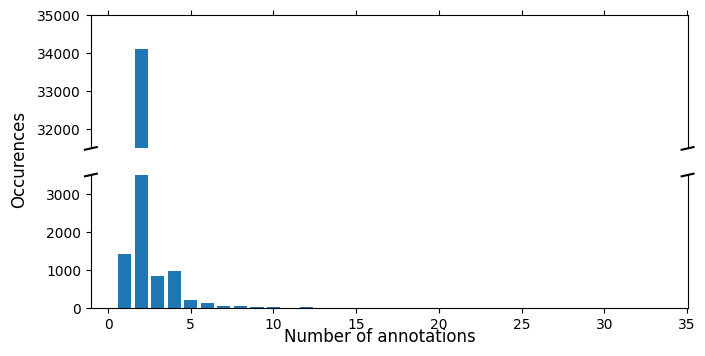

In [33]:
import matplotlib.pyplot as plt

# input annotator distribution
def showAnnotatorDistribution(trainContainer):
    dstr = trainContainer.RawY.apply(lambda ls: len(ls.split("/")))
    counts = Counter(dstr)
    val, amount = zip(*(sorted(counts.items())))

    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)
    fig.set_size_inches(7.7, 3.8)

    ax.set_ylim(31500, 35000)  # outliers only
    ax2.set_ylim(0, 3500)  # most of the data

    ax.spines['bottom'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=False)  # don't put tick labels at the top
    ax2.xaxis.tick_bottom()

    d = .01  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

    fig.supxlabel("Number of annotations")
    fig.supylabel("Occurences")

    ax.bar(val, amount)
    ax2.bar(val, amount)
    
showAnnotatorDistribution(trainContainer)

In [5]:
############
# Bert Setup
############
from transformers import BertTokenizer, BertForSequenceClassification

bertTokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased'
)
bertModel = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=2
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [6]:
# max tweet = 240 characters -> 120 words
# must const sizes or torch gets angry
from sklearn.model_selection import train_test_split 
X_train, X_val, y_train, y_val = train_test_split(trainContainer.RawX, train_mostPopClass, test_size=0.2)

train_Xtoken = bertTokenizer(list(X_train), max_length=120, padding=True, truncation=True) 
eval_Xtoken  = bertTokenizer(list(X_val),  max_length=120, padding=True, truncation=True)

In [7]:
trainY = [int(x) for x in list(y_train)]
evalY = [int(x) for x in list(y_val)]

trainTset = TDataset(train_Xtoken, trainY)
evalTset = TDataset(eval_Xtoken, evalY)

#Making sure sizes are correct
print(len(train_Xtoken["input_ids"]))
print(len(train_Xtoken["token_type_ids"]))
print(len(train_Xtoken["attention_mask"]))
print(len(trainY))

30308
30308
30308
30308


In [8]:
def getScores(torchDataSet):
    pred, labels = torchDataSet
    pred = np.argmax(pred, axis=1)

    recall = sk.metrics.recall_score(y_true=labels, y_pred=pred)
    precision = sk.metrics.precision_score(y_true=labels, y_pred=pred)
    f1 = sk.metrics.f1_score(y_true=labels, y_pred=pred)

    return {
        "precision": precision, 
        "recall": recall, 
        "f1": f1
    }

In [9]:
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback

#https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=1337,
    load_best_model_at_end=True,
)
trainer = Trainer(
    model=bertModel,
    args=args,
    train_dataset=trainTset,
    eval_dataset=evalTset,
    compute_metrics=getScores,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [10]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [11]:
#RUN 
#trainer.train()

# Testing

In [12]:
trainedPath = "output/checkpoint-4500"
trainedModel = BertForSequenceClassification.from_pretrained(trainedPath, num_labels=2)

test_trainer = Trainer(
    model=trainedModel
)

loading configuration file output/checkpoint-4500\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file output/checkpoint-4500\pytorch_model.bin
All model checkpoint weights were used when initializing BertForSequenceClassification.

All the weights of BertForSequenceC

In [13]:
nTake = min(100, len(testContainer.RawX))

test_X = list(testContainer.RawX)[:nTake]
test_Xtoken = bertTokenizer(list(testContainer.RawX)[:nTake], max_length=120, padding=True, truncation=True) 
testYtrue = [int(x) for x in list(testContainer.RawY)[:nTake]] # no split consensus for test

testTset = TDataset(test_Xtoken)

In [14]:
#test_X = X_train
#testYtrue = y_train

In [17]:
raw_pred, _, _ = test_trainer.predict(testTset)
#raw_pred, _, _ = test_trainer.predict(trainTset)

***** Running Prediction *****
  Num examples = 100
  Batch size = 8
100%|██████████| 13/13 [00:18<00:00,  1.40s/it]


In [18]:
y_pred = np.argmax(raw_pred, axis=1)

df = pd.DataFrame()
df["text"] = test_X
df["true_opinion"] = testYtrue
df["predicted_opinion"] = y_pred

In [19]:
recall    = sk.metrics.recall_score(    y_true=df["true_opinion"], y_pred=df["predicted_opinion"])
precision = sk.metrics.precision_score( y_true=df["true_opinion"], y_pred=df["predicted_opinion"])
f1        = sk.metrics.f1_score(        y_true=df["true_opinion"], y_pred=df["predicted_opinion"])
accuracy  = sk.metrics.accuracy_score(  y_true=df["true_opinion"], y_pred=df["predicted_opinion"])

falseNegatives = df.query("`true_opinion` == 1 and `predicted_opinion` == 0")
falsePositives = df.query("`true_opinion` == 0 and `predicted_opinion` == 1")
corrects = df.query("`true_opinion` == `predicted_opinion`")

testFile = trainContainer.File
#testFile = testContainer.File

In [20]:
pd.set_option('display.max_colwidth', 0)

testFrame = pd.DataFrame.from_dict({
    "test file": [testFile],
    "model path": [trainedPath],
    "recall": [recall],
    "precision": [precision],
    "f1": [f1],
    "accuracy": [accuracy],
    "#samples": [df.shape[0]],
    "  #correct samples": [corrects.shape[0]],
    "  #false negatives": [falseNegatives.shape[0]],
    "  #false positives": [falsePositives.shape[0]],
}, orient="index")
display(testFrame)

display("False Negatives", falseNegatives.head())
display("False Positives", falsePositives.head())
display("Correct", corrects.head())

import re
def alphnum(s):
    return re.sub("[^0-9a-zA-Z]+", "_", s)

try:
    os.mkdir("test_results")
except Exception:
    ""
falseNegatives.to_csv(f"test_results/{df.shape[0]}_{alphnum(testFile)}_{alphnum(trainedPath)}_False_Negatives.csv")
falsePositives.to_csv(f"test_results/{df.shape[0]}_{alphnum(testFile)}_{alphnum(trainedPath)}_False_Positives.csv")
corrects.to_csv(f"test_results/{df.shape[0]}_{alphnum(testFile)}_{alphnum(trainedPath)}_Correct.csv")
testFrame.to_csv(f"test_results/{df.shape[0]}_{alphnum(testFile)}_{alphnum(trainedPath)}_STAT.csv")

,0
test file,assets/a3_train_final.tsv
model path,output/checkpoint-4500
recall,0.9375
precision,0.865385
f1,0.9
accuracy,0.9
#samples,100
#correct samples,90
#false negatives,3
#false positives,7


'False Negatives'

,text,true_opinion,predicted_opinion
13,all i can say is wow!!,1,0
27,"odd, as a man living with hiv for 23 years, and vaccinated twice plus two boosters, my t cells were just tested and were by far the highest they've been in 15 years. one might almost think sherry tenpenny is lying.",1,0
60,"everybody, finishing something quickly doesn't mean it is rushed",1,0


'False Positives'

,text,true_opinion,predicted_opinion
7,"vaccines do not cause autism. sure. i have autistic daughter. when she was 8 month she was vaccinated (6in1). next day she got fever, she got normal after 3-4 days. but after 2 weeks she stopped to laugh, look in the eyes and play with her toys. she became quiet, kind of thinking inside. now she's 10 yo. she can't talk and shows typical autism symptoms. i've done her hair analysis and it clearly showed that after vaccination the level of aluminium in her body raised multiple times above secure levels. continue to lie.",0,1
31,the fact that can use the logic of “this is a extremely rare side effect” and still force the vaccine but cant use the same logic of its extremely rare for me to die of covid regardless if i’m vaccinated is really aggravating,0,1
35,i was anti vaxxed and i have not gotten sick for 3 years before and how are wild animals ok if they were not vaccinated?,0,1
65,one thing about being a so called conspiracy theorist is that i will not have to worry about any of the side effects,0,1
66,"im good, ill take my chances.",0,1


'Correct'

,text,true_opinion,predicted_opinion
0,getting mine in a week and i'm so stoked,1,1
1,"the new classical vaccines ( without mrna and graphen) function perfectly as boosters so e.g. novavax, without devastating side effects.",1,1
2,i have had four covid shots and i feel great.,1,1
3,forcing healthy people to take medicine they don't need is a crime.,0,0
4,i'm so excited about the vaccine! i wish we could get it right now. this is fantastic news! merry christmas everyone! 🎆💖🎄☃️☮️😊,1,1


## Importance scores
captum usages is based off https://captum.ai/tutorials/Bert_SQUAD_Interpret

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

imodel_path = "output/checkpoint-4500"

# load model
imodel = trainedModel
imodel.to(device)
imodel.eval()
imodel.zero_grad()

# load tokenizer
itokenizer = bertTokenizer

In [22]:

def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = imodel(
        inputs, 
        token_type_ids=token_type_ids,
        position_ids=position_ids, 
        attention_mask=attention_mask, 
    )
    return output.logits, output.logits

def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [23]:
ref_token_id = itokenizer.pad_token_id # A token used for generating token reference
sep_token_id = itokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = itokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [24]:
def construct_input_ref_pair(question, ref_token_id, sep_token_id, cls_token_id):
    question_ids = itokenizer.encode(question, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id]

    # construct reference token ids 
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids
    
def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(
    input_ids, ref_input_ids, 
    token_type_ids=None, 
    ref_token_type_ids=None,
    position_ids=None, 
    ref_position_ids=None
):
    input_embeddings = imodel.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = imodel.bert.embeddings(ref_input_ids, token_type_ids=ref_token_type_ids, position_ids=ref_position_ids)
    
    return input_embeddings, ref_input_embeddings

In [25]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [42]:
from captum.attr import visualization as viz
from captum.attr import LayerConductance, LayerIntegratedGradients
def getVisualizerFromSentence(text=None, trueClass=None):
    if text == None:
        return None
    exampleText = text
    input_ids, ref_input_ids, sep_id = construct_input_ref_pair(exampleText, ref_token_id, sep_token_id, cls_token_id)
    token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
    position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
    attention_mask = construct_attention_mask(input_ids)

    indices = input_ids[0].detach().tolist()
    all_tokens = itokenizer.convert_ids_to_tokens(indices)

    start_scores, end_scores = predict(
        input_ids,
        token_type_ids=token_type_ids,
        position_ids=position_ids,
        attention_mask=attention_mask
    )

    lig = LayerIntegratedGradients(squad_pos_forward_func, imodel.bert.embeddings) #.word_embeddings.weight

    attributions_start, delta_start = lig.attribute(
        inputs=input_ids,
        baselines=ref_input_ids,
        additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
        return_convergence_delta=True
    )

    attributions_start_sum = summarize_attributions(attributions_start)

    arg_tokens = itokenizer.encode(exampleText, add_special_tokens=False)
    arg_end_ind = indices.index(arg_tokens[-1])
    arg_start_ind = arg_end_ind - len(arg_tokens) + 1

    start_position_vis = viz.VisualizationDataRecord(
        attributions_start_sum,
        torch.max(torch.softmax(start_scores[0], dim=0)),
        torch.argmax(start_scores),
        trueClass,
        str(arg_start_ind),
        attributions_start_sum.sum(),       
        all_tokens,
        delta_start
    )
    return start_position_vis

In [62]:
# Correct Positive classifications
correctPos = [
    getVisualizerFromSentence(trueClass=1, text="unicef you are doing and distributing vaccines booster covid-19 make for more confident and safe for people.thank you so much."),
    getVisualizerFromSentence(trueClass=1, text="getting mine in a week and i'm so stoked"),
    getVisualizerFromSentence(trueClass=1, text="i'm so excited about the vaccine! i wish we could get it right now. this is fantastic news! merry christmas everyone! 🎆💖🎄☃️☮️😊"),
    getVisualizerFromSentence(trueClass=1, text="i will get the vaccine"),
]

In [63]:
# Correct Negative classifications
correctNeg = [
    getVisualizerFromSentence(trueClass=0, text="forcing healthy people to take medicine they don't need is a crime."),
    getVisualizerFromSentence(trueClass=0, text="some side effects are normal like death"),
    getVisualizerFromSentence(trueClass=0, text="vaccine are poison!"),
    getVisualizerFromSentence(trueClass=0, text="everyone should be refusing to be a guinea pig in this eugenics experiment"),
]

In [67]:
# False Negatives
falseNeg = [
    getVisualizerFromSentence(trueClass=1, text="did you not read the article. it said vaccine is good"),
    getVisualizerFromSentence(trueClass=1, text="back in my day, we didn't have vaccines. we just died."),
    getVisualizerFromSentence(trueClass=1, text="a similar vaccine, had a similar case during clinical trials"),
    getVisualizerFromSentence(trueClass=1, text="i got my moderna vaccine and now i'm a wifi hotspot"),
]

In [65]:
# False Positives
falsePos = [    
    getVisualizerFromSentence(trueClass=0, text="i was anti vaxxed and i have not gotten sick for 3 years before and how are wild animals ok if they were not vaccinated?"),
    getVisualizerFromSentence(trueClass=0, text="one thing about being a so called conspiracy theorist is that i will not have to worry about any of the side effects"),
    getVisualizerFromSentence(trueClass=0, text="im good, ill take my chances."),
    getVisualizerFromSentence(trueClass=0, text="we take other risks so taking this one shouldnt be a problem is the dumbest argument there is..."),
]

In [68]:
viz.visualize_text(correctPos)
viz.visualize_text(correctNeg)
viz.visualize_text(falseNeg)
viz.visualize_text(falsePos)
_=1

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.98),1,0.46,[CLS] forcing healthy people to take medicine they don ' t need is a crime . [SEP]
0,0 (0.97),1,0.48,[CLS] some side effects are normal like death [SEP]
0,0 (1.00),1,1.59,[CLS] vaccine are poison ! [SEP]
0,0 (1.00),1,0.35,[CLS] everyone should be refusing to be a guinea pig in this eugen ##ics experiment [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,0 (0.95),1,0.25,[CLS] did you not read the article . it said vaccine is good [SEP]
1,0 (1.00),-3,1.07,"[CLS] back in my day , we didn ' t have vaccines . we just died . [SEP]"
1,0 (0.95),1,0.87,"[CLS] a similar vaccine , had a similar case during clinical trials [SEP]"
1,0 (0.88),1,0.47,[CLS] i got my modern ##a vaccine and now i ' m a wi ##fi hot ##sp ##ot [SEP]
